# Neural Network Classifier & Regressor

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

from typing import Union
from qiskit.algorithms.optimizers import L_BFGS_B, COBYLA

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

In [2]:
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'))

## Classification

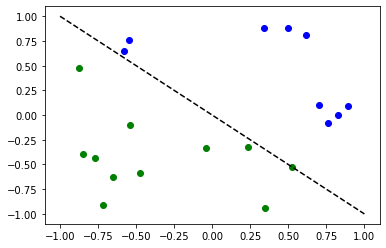

In [3]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

### Classification with the an `OpflowQNN`

In [4]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [5]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], np.random.rand(opflow_qnn.num_weights))

array([[-0.19219741]])

In [6]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=L_BFGS_B())

In [7]:
# fit classifier to data
opflow_classifier.fit(X, y)

# print results from fitting
print(opflow_classifier._fit_result)

(array([-0.1339697 ,  1.33890762,  0.30209517,  1.31090456,  0.26760587,
        1.51343104, -0.42589472,  0.08744876]), 11.874985311649343, 16)


In [8]:
# score classifier
opflow_classifier.score(X, y)

0.85

In [9]:
# plot results

### Classification with a `CircuitQNN`

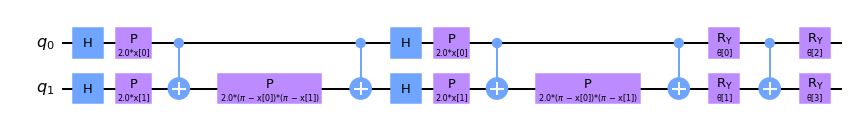

In [10]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct variational form
var_form = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(var_form, range(num_inputs))
qc.decompose().draw(output='mpl')

In [11]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return '{:b}'.format(x).count('1') % 2
output_shape = 2

In [12]:
# construct QNN
circuit_qnn = CircuitQNN(qc, input_params=feature_map.parameters,
                         weight_params=var_form.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

In [13]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(circuit_qnn, optimizer=COBYLA())

In [14]:
# fit classifier to data
circuit_classifier.fit(X, y01)

# print results from fitting
print(circuit_classifier._fit_result)

(array([-0.16893593, -0.64820979,  0.67807974,  1.23828635]), 7.225690660137013, 93)


In [15]:
# score classifier
circuit_classifier.score(X, y01)

0.8

In [16]:
# plot results

### Variational Quantum Classifier

In [17]:
# show how CircuitQNN links to VQC...

## Regression

In [18]:
# show how to use OpflowQNN to do regression... same example as for TorchConnector